In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [2]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [19]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]]

In [4]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [5]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [62]:
dataname = 'ELG_80606_Cascades_subsamples.fits'
dataname = 'allVItiles_ELGzinfo_wVI.fits'
dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'

new_catalog = pf.getdata(dir+dataname,1)
#print(len(SV_depth_catalog))
#Reading Ashley's SV1 ELG catalog with VI 

In [63]:
SV_depth_catalog = sub_sample_based_on_depth(new_catalog, 3000, 4200)[0:2500]
print(len(SV_depth_catalog))

2500


In [64]:
good_catalog,bad_catalog = good_robust_redrock_redshift(SV_depth_catalog)
print(len(good_catalog),len(bad_catalog))

1816 684


(array([ 37.,  57.,  67.,  90., 105.,  79.,  82.,  41.,  29.,  15.,   4.,
          3.,   1.,   2.,   1.,   2.,   0.,   0.,   1.,   0.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <a list of 20 Patch objects>)

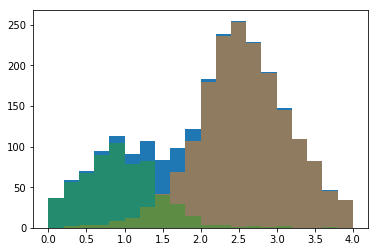

In [65]:
plt.hist(np.log10(SV_depth_catalog['DELTACHI2']),range=(0,4),bins=20)
plt.hist(np.log10(good_catalog['DELTACHI2']),range=(0,4),bins=20,alpha=0.5)
plt.hist(np.log10(bad_catalog['DELTACHI2']),range=(0,4),bins=20,alpha=0.5)
#plt.hist(np.log10(SV_depth_catalog['DELTACHI2'][SV_depth_catalog['ZWARN']==4]),range=(0,4),bins=50,alpha=0.5)

In [66]:
log_delta_bin = my_wise_ut.my_bin_maker(0,4,20)
x_all = np.log10(SV_depth_catalog['DELTACHI2'])
print(len(x_all))
x_good = np.log10(good_catalog['DELTACHI2'])
print(len(x_good))

2500
1816


Text(0.5, 0, 'Fiber id')

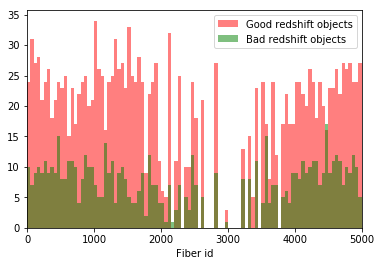

In [67]:
#plt.hist(good_catalog['Z'],normed=1,bins=20,range=(0,2))
plt.hist(good_catalog['fiber'],bins=100,range=(0,5000),alpha=0.5,color='r',label='Good redshift objects')
plt.hist(bad_catalog['fiber'],bins=100,range=(0,5000),alpha=0.5,color='g',label='Bad redshift objects')
plt.legend()
plt.xlim(-1,5000)
plt.xlabel('Fiber id')

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0.   , 0.075, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
        0.675, 0.75 , 0.825, 0.9  , 0.975, 1.05 , 1.125, 1.2  , 1.275,
        1.35 , 1.425, 1.5  ]),
 <a list of 20 Patch objects>)

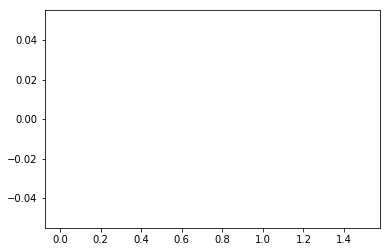

In [68]:
search = np.where((bad_catalog['fiber']>2660) & (bad_catalog['fiber']<2690))
plt.hist(bad_catalog['Z'][search[0]],range=(0,1.5),bins=20)

In [69]:
dz = abs(bad_catalog['Z']-bad_catalog['best_z'])/(1.+bad_catalog['best_z'])
qq = bad_catalog['best_quality']
type_o = bad_catalog['best_spectype']
print('TARGETID, TILEID, Type, Redrock_z, fiberid')
data_dict = {}
for index in range(0,len(search[0])):
    i = search[0][index]
    print(bad_catalog['TARGETID'][i],bad_catalog['TILEID'][i],type_o[i],bad_catalog['Z'][i],bad_catalog['fiber'][i])#,bad_catalog['petal_loc'][i])
    data_dict[index]=get_specs(tileid=bad_catalog['TILEID'][i], night='deep', fiber=bad_catalog['fiber'][i], coadd=True)

TARGETID, TILEID, Type, Redrock_z, fiberid


In [70]:
plt.figure(figsize=(20,20))
for index in range(0,len(search[0])):
    plt.subplot(6,6,index+1)
    plt.plot(data_dict[index][0]['z_wavelength'],sn.median_filter(data_dict[index][0]['z_flux'],51))

<Figure size 1440x1440 with 0 Axes>

In [71]:
all_number = []
good_number = []
for i_bin in range(0,len(log_delta_bin['average_bin'])):
    search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
    all_number.append(len(search[0]))
    
    search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
    good_number.append(len(search[0]))
    
print(all_number)
print(good_number)

[38, 64, 74, 107, 120, 88, 114, 79, 112, 164, 231, 277, 246, 205, 170, 125, 82, 57, 37]
[0, 2, 4, 3, 12, 11, 35, 47, 87, 153, 228, 276, 244, 204, 168, 125, 82, 56, 37]


(0.6, 1.05)

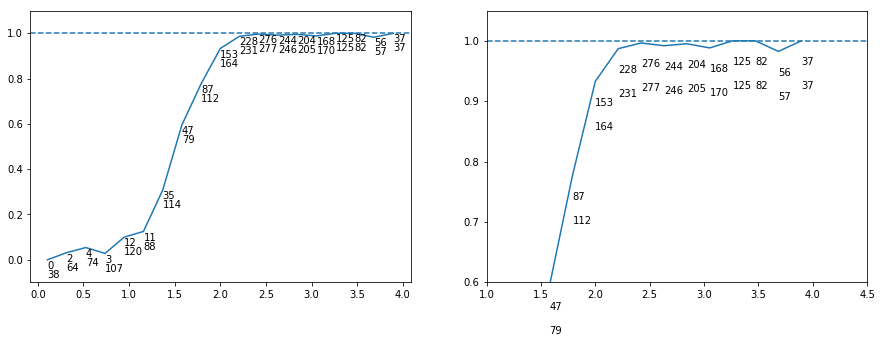

In [72]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.axhline(1.,ls='--')
plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
for i_bin in range(0,len(log_delta_bin['average_bin'])):
    plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
    plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)
plt.axhline(1.,ls='--')
plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
for i_bin in range(7,len(log_delta_bin['average_bin'])):
    plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
    plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

plt.xlim(1,4.5)
plt.ylim(0.6,1.05)

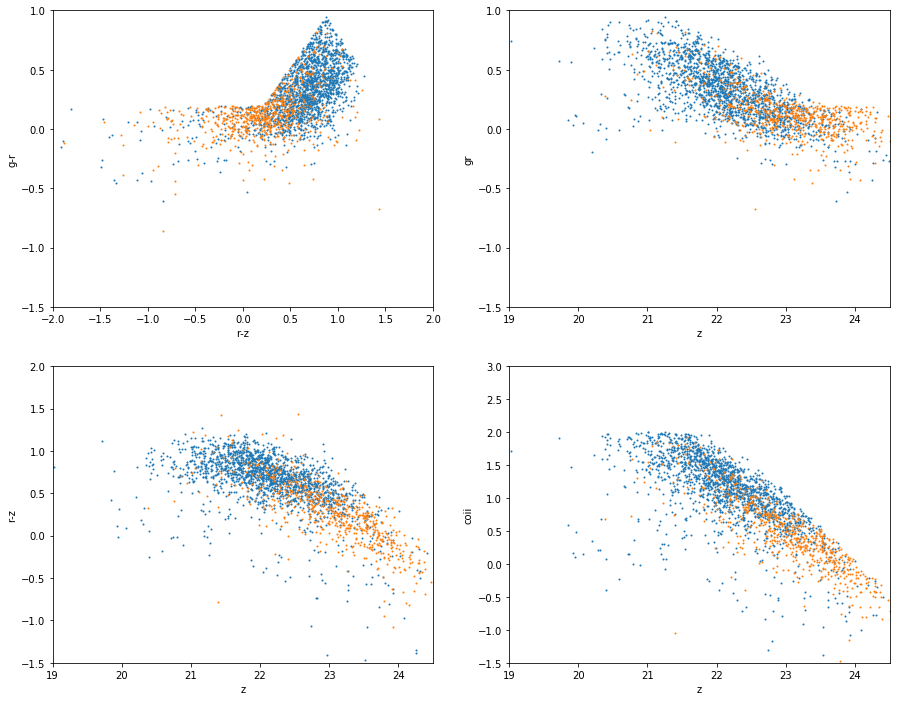

In [73]:
plt.figure(figsize=(15,12))
plot_ELG_cc_plot(good_catalog)
plot_ELG_cc_plot(bad_catalog)

In [74]:
len(np.where(x_all<2)[0])

943

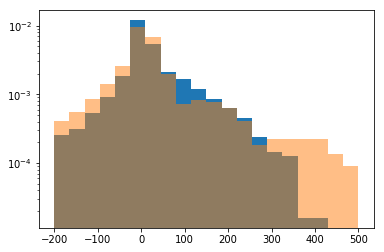

In [75]:
#good_search = (good_catalog['Z']>0.95) & (good_catalog['Z']<1.0)
plt.hist(good_catalog['coeff'].T[3],range=(-200,500),bins=20,normed=1)
plt.hist(bad_catalog['coeff'].T[3],range=(-200,500),bins=20,alpha=0.5,normed=1)
plt.yscale('log')

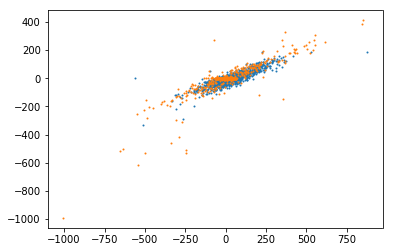

In [76]:
plt.scatter(good_catalog['coeff'].T[3],good_catalog['coeff'].T[5],s=1)
plt.scatter(bad_catalog['coeff'].T[3],bad_catalog['coeff'].T[5],s=1)

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
X = np.zeros((len(good_catalog['coeff']),16))
X[:,0:10]=good_catalog['coeff']
X[:,10]=good_catalog['DELTACHI2']
output = flux_to_mag(good_catalog)
X[:,11]=output['gr']
X[:,12]=output['rz']
X[:,13]=good_catalog['Z']
X[:,14]=output['coii']
X[:,15]=abs(good_catalog['coeff'].T[3]**2)*abs(good_catalog['coeff'].T[5]**2)


X2 = np.zeros((len(bad_catalog['coeff']),16))
X2[:,0:10]=bad_catalog['coeff']
X2[:,10]=bad_catalog['DELTACHI2']
output = flux_to_mag(bad_catalog)
X2[:,11]=output['gr']
X2[:,12]=output['rz']
X2[:,13]=bad_catalog['Z']
X2[:,14]=output['coii']
X2[:,15]=abs(bad_catalog['coeff'].T[3]**2)*abs(bad_catalog['coeff'].T[5]**2)

X = np.append(X,X2,axis=0)
y = np.zeros((len(X)))
y[0:len(good_catalog['coeff'])]=np.int64(1)
y[len(good_catalog['coeff']):]=np.int64(0)

clf = RandomForestClassifier(random_state=0,max_depth=7)
clf.fit(X, y)

svf = svm.SVC(kernel='poly',degree=10)
svf.fit(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [78]:
clf.score(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


0.9824

In [79]:
svf.score(X,y)

0.7264

In [84]:
SV_depth_catalog2 = sub_sample_based_on_depth(new_catalog, 3000, 4500)[2500:]
good_catalog,bad_catalog = good_robust_redrock_redshift(SV_depth_catalog2)
X = np.zeros((len(good_catalog['coeff']),16))
X[:,0:10]=good_catalog['coeff']
X[:,10]=good_catalog['DELTACHI2']
output = flux_to_mag(good_catalog)
X[:,11]=output['gr']
X[:,12]=output['rz']
X[:,13]=good_catalog['Z']
X[:,14]=output['coii']
X[:,15]=abs(good_catalog['coeff'].T[3]**2)*abs(good_catalog['coeff'].T[5]**2)


X2 = np.zeros((len(bad_catalog['coeff']),16))
X2[:,0:10]=bad_catalog['coeff']
X2[:,10]=bad_catalog['DELTACHI2']
output = flux_to_mag(bad_catalog)
X2[:,11]=output['gr']
X2[:,12]=output['rz']
X2[:,13]=bad_catalog['Z']
X2[:,14]=output['coii']
X2[:,15]=abs(bad_catalog['coeff'].T[3]**2)*abs(bad_catalog['coeff'].T[5]**2)

X = np.append(X,X2,axis=0)
y = np.zeros((len(X)))
y[0:len(good_catalog['coeff'])]=np.int64(1)
y[len(good_catalog['coeff']):]=np.int64(0)

In [85]:
clf.score(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


0.9353262431733257

In [82]:
svf.score(X,y)

0.712848519689566

In [86]:
clf.feature_importances_

array([0.01810851, 0.01085025, 0.01168277, 0.00858602, 0.0688775 ,
       0.03733375, 0.00779174, 0.01921601, 0.01701798, 0.01378071,
       0.43300044, 0.02323719, 0.17436971, 0.06206996, 0.0522642 ,
       0.04181325])

In [56]:
new_predict = clf.predict(X)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [57]:
probability = clf.predict_proba(X)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [58]:
Trust = []
for i in range(0,len(new_predict)):
    if np.max(probability[i])>0.8:
        Trust.append(1)
    else:
        Trust.append(0)

In [59]:
np.sum(abs(new_predict[np.where(np.array(Trust)==1)[0]]-y[np.where(np.array(Trust)==1)[0]]))


62.0

In [60]:
len(np.where(np.array(Trust)==1)[0])

4734

In [61]:
len(Trust)

5479